First few rows of the dataset:
    Z0        W0 W1     v0         y
0  0.0  0.396769  3   True  3.612239
1  0.0 -0.485073  1  False  0.857056
2  0.0  1.328293  3   True  3.641252
3  1.0 -0.720394  2   True  2.714787
4  0.0 -0.714337  1   True  1.851852

Identified Estimand:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                      -1⎤
 ⎢  d      ⎛  d        ⎞  ⎥
E⎢─────(y)⋅⎜─────([v₀])⎟  ⎥
 ⎣d[Z₀]    ⎝d[Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0})
Estimand assumption 2, Exclusion: If we remove {Z0}→{v0}, then ¬({Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

instrumental_variable

Causal Effect estimate using IV:
0.9643793965865842

Refutation Result:
Refute: A

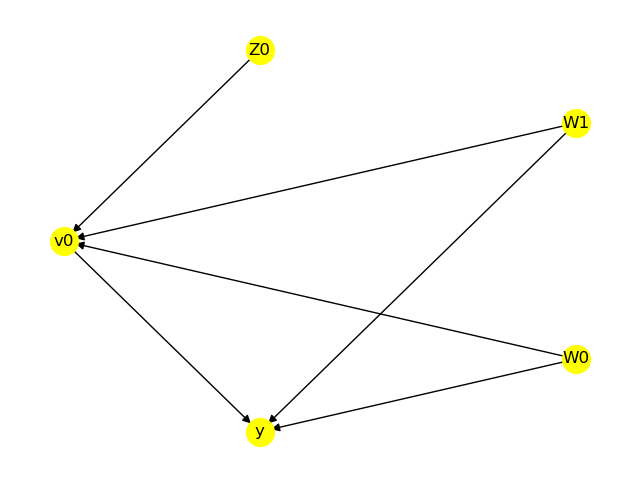

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Instrumental Variable Analysis using DoWhy
# This example simulates a scenario where an instrumental variable (Z0) affects the treatment (v0) 
# and, in turn, the treatment affects the outcome (y). The instrument is assumed to affect the outcome
# only indirectly through the treatment, satisfying one of the key assumptions for IV estimation.

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

# 1. Data Simulation
# ------------------
# Set a random seed for reproducibility
np.random.seed(42)

# Generate a synthetic dataset using DoWhy's linear_dataset function.
# Parameters:
# - beta: the true causal effect of the treatment on the outcome.
# - num_common_causes: number of confounders that influence both treatment and outcome.
# - num_discrete_common_causes: number of discrete confounders.
# - num_instruments: number of instrumental variables.
# - num_samples: total number of samples for our simulation.
# - treatment_is_binary: whether the treatment variable is binary.
data = dowhy.datasets.linear_dataset(
    beta=1.0,
    num_common_causes=2,
    num_discrete_common_causes=1,
    num_instruments=1,
    num_samples=10000,
    treatment_is_binary=True
)

# Extract the dataframe from the generated dataset.
df = data['df']

# Optionally, inspect the first few rows to understand the dataset structure.
print("First few rows of the dataset:")
print(df.head())

# 2. Causal Model Setup
# ---------------------
# Build the causal model by specifying:
# - data: the simulated dataframe.
# - treatment: the treatment variable name.
# - outcome: the outcome variable name.
# - common_causes: list of confounding variable names that affect both the treatment and outcome.
# - instruments: list of potential instrumental variable(s) that affect treatment but not directly the outcome.
model = CausalModel(
    data=df,
    treatment=data['treatment_name'],       # Typically 'v0'
    outcome=data['outcome_name'],           # Typically 'y'
    common_causes=data['common_causes_names'],  # e.g., ['W0', 'W1'] if provided
    instruments=data['instrument_names']        # e.g., ['Z0']
)

# (Optional) Visualize the causal graph.
# This creates a visual representation of the assumed relationships among variables.
# In an interactive environment, the image file "causal_model.png" can be opened to inspect the graph.
model.view_model()

# 3. Identification of the Causal Effect
# --------------------------------------
# Identify whether the causal effect can be estimated from the data given our assumptions.
identified_estimand = model.identify_effect()
print("\nIdentified Estimand:")
print(identified_estimand)

# 4. Estimation Using the Instrumental Variable Method
# -----------------------------------------------------
# Estimate the causal effect using an IV-based approach.
# Here, we use the "iv.instrumental_variable" method which leverages the instrument to estimate the effect.
iv_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable"
)
print("\nCausal Effect estimate using IV:")
print(iv_estimate.value)

# 5. Robustness Check (Optional)
# ------------------------------
# Optionally, we can perform a refutation test to check the robustness of the estimated effect
# by simulating a random common cause. This helps assess the sensitivity of the result.
refutation = model.refute_estimate(
    identified_estimand, 
    iv_estimate,
    method_name="random_common_cause"
)
print("\nRefutation Result:")
print(refutation)


---

### Identified Estimand

The identified estimand is the target of our analysis, which is to estimate the causal effect of a treatment (`v0`) on an outcome (`y`). There are three types of estimands mentioned:

1. **Backdoor Estimand**:
   - **Estimand Expression**: This represents the effect of the treatment (`v0`) on the outcome (`y`) while controlling for confounders (`W0`, `W1`).
   - **Assumption**: Unconfoundedness. This means that once we control for all confounders (`W0`, `W1`), there should be no other unmeasured factors (`U`) that affect both the treatment and the outcome. Think of it like trying to understand how exercise affects weight while accounting for diet and genetics.

2. **IV Estimand**:
   - **Estimand Expression**: This formula calculates the causal effect using an instrumental variable (`Z0`). It essentially measures how changes in the outcome (`y`) are related to changes in the treatment (`v0`) that are caused by changes in the instrument (`Z0`).
   - **Assumptions**:
     - **As-if-random**: The instrument (`Z0`) should not be directly affected by unmeasured factors (`U`) that also affect the outcome (`y`). It's like using a random lottery to decide who gets a new medicine, ensuring that the decision isn't biased by other factors.
     - **Exclusion**: The instrument (`Z0`) should only affect the outcome (`y`) through its effect on the treatment (`v0`). For example, if a new policy (`Z0`) increases the availability of a drug (`v0`), and this policy doesn't directly affect health outcomes (`y`) except through the drug, then the exclusion assumption is met.

3. **Frontdoor Estimand**:
   - This is not applicable in our scenario because we don't have a mediator variable that fits the frontdoor criteria.

### Causal Effect Estimate Using IV

- **Estimated Effect**: `0.9643793965865842`
  - This is the estimated causal effect of the treatment (`v0`) on the outcome (`y`) using the instrumental variable (`Z0`). It means that for every unit increase in the treatment caused by the instrument, the outcome increases by approximately 0.964 units.

### Refutation Result

- **Refute: Add a random common cause**
  - This test adds a random variable as a common cause to see if it changes the estimated effect. If the effect remains stable, it suggests that our model is robust against unmeasured confounding.
  - **Estimated effect** and **New effect** are the same (`0.9643793965865842`), indicating that adding a random common cause does not alter the estimated causal effect.
  - **p-value: 1.0**
    - This p-value indicates that we cannot reject the null hypothesis that the estimated effect is unchanged when adding a random common cause. Essentially, it means our result is robust to this specific type of confounding.

In summary, the results suggest that using the instrumental variable method, we can estimate a strong causal effect of the treatment on the outcome, and this effect appears robust to potential unmeasured confounding based on the refutation test.

---